In [27]:
# Setup Environment
import time
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import os
import logging
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
import joblib # Used for encoding horse_id
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import optuna
import optuna.visualization as viz
from catboost import CatBoostRanker, CatBoostRegressor, CatBoostClassifier, Pool
import numpy as np
import itertools
import pyspark.sql.functions as F
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   row_number, mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment 
# Set global references to None
spark = None
master_results_df = None
race_df = None
df = None
training_data = None
train_df = None

In [28]:
spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()

Spark session created successfully.


In [54]:
train_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/train_df")
global_speed_score = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/global_speed_score.parquet")
horse_embedding = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/horse_embedding_data-20250304_1409.parquet")

In [59]:
# Load historical and future data from Spark.
historical_df_spark = horse_embedding.filter(F.col("data_flag") == "historical")
future_df = horse_embedding.filter(F.col("data_flag") == "future")


In [63]:
from pyspark.sql import functions as F

for col in future_df.columns:
    null_count = future_df.filter(F.col(col).isNull()).count()
    if null_count > 0:
        print(f"{col}: {null_count} null values")

official_fin: 589 null values
running_time: 589 null values
dist_bk_gate4: 589 null values
total_distance_ran: 589 null values
relevance: 589 null values
top4_label: 589 null values
base_speed: 589 null values
wide_factor: 589 null values
par_time: 589 null values
par_diff_ratio: 589 null values
raw_performance_score: 589 null values
standardized_score: 526 null values
logistic_score: 526 null values
median_logistic: 526 null values
median_logistic_clamped: 526 null values
global_speed_score_iq: 526 null values
race_avg_speed_agg: 370 null values
race_std_speed_agg: 493 null values
race_avg_relevance_agg: 589 null values
race_class_avg_speed_agg: 370 null values
race_class_std_speed_agg: 493 null values
race_class_min_speed_agg: 370 null values
race_class_max_speed_agg: 370 null values


In [61]:
for col in historical_df_spark.columns:
    null_count = historical_df_spark.filter(F.col(col).isNull()).count()
    if null_count > 0:
        print(f"{col}: {null_count} null values")

In [57]:
global_speed_score.printSchema()

root
 |-- horse_id: double (nullable = true)
 |-- race_class_id: string (nullable = true)
 |-- group_id: string (nullable = true)
 |-- class_rating: double (nullable = true)
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: double (nullable = true)
 |-- axciskey: string (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- horse_name: string (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- time_behind: double (nullable = true)
 |-- pace_delta_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- dist_bk_gate4: double (nullable = true)
 |-- total_distance_ran: double (nullable = true)
 |-- speed_rating: double (nullable = true)
 |-- prev_speed_rating: double (nullable = true)
 |-- previous_class: double (nullable = true)
 |-- purse: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- date_of_birth: date (nullable = t

In [6]:
# Separate historical and future data
historical_df = global_speed_score.filter(F.col("data_flag") == "historical")
future_df = global_speed_score.filter(F.col("data_flag") == "future")


In [33]:
from pyspark.sql.types import FloatType, DoubleType
import pyspark.sql.functions as F

# Get all numeric columns (float and double)
numeric_cols = [field.name for field in global_speed_score.schema.fields 
                if field.dataType.typeName() in ['double', 'float']]

cols_with_issues = []

for col_name in numeric_cols:
    # Count NaN values
    nan_count = global_speed_score.filter(F.isnan(F.col(col_name))).count()
    # Count positive infinity values
    pos_inf_count = global_speed_score.filter(F.col(col_name) == float("inf")).count()
    # Count negative infinity values
    neg_inf_count = global_speed_score.filter(F.col(col_name) == float("-inf")).count()
    total_issues = nan_count + pos_inf_count + neg_inf_count
    if total_issues > 0:
        cols_with_issues.append({
            "column": col_name,
            "total_issues": total_issues,
            "nan_count": nan_count,
            "pos_inf_count": pos_inf_count,
            "neg_inf_count": neg_inf_count
        })

print("Numeric columns with NaN or Infinity values:")
for info in cols_with_issues:
    print(f"{info['column']}: total issues={info['total_issues']} (NaN: {info['nan_count']}, +Inf: {info['pos_inf_count']}, -Inf: {info['neg_inf_count']})")

Numeric columns with NaN or Infinity values:


In [34]:
count_hist = global_speed_score.filter(F.col("data_flag") == "historical").count()
count_fut = global_speed_score.filter(F.col("data_flag") == "future").count()
count_total = global_speed_score.count()

print(f"Final DF total count: {count_total}")
print(f"Final DF count for historical: {count_hist}")
print(f"Final DF count for future: {count_fut}")

Final DF total count: 778310
Final DF count for historical: 776892
Final DF count for future: 1418


In [35]:
# Show basic descriptive stats for global_speed_score
global_speed_score_stats = global_speed_score.select("global_speed_score_iq").describe()
global_speed_score_stats.show()

+-------+---------------------+
|summary|global_speed_score_iq|
+-------+---------------------+
|  count|               778310|
|   mean|    100.0077295836801|
| stddev|    8.523255338689708|
|    min|   52.888707209637474|
|    max|   140.82256054265082|
+-------+---------------------+



In [36]:
global_speed_score_quantiles = global_speed_score.select("global_speed_score_iq").summary()
global_speed_score_quantiles.show()

+-------+---------------------+
|summary|global_speed_score_iq|
+-------+---------------------+
|  count|               778310|
|   mean|    100.0077295836801|
| stddev|    8.523255338689708|
|    min|   52.888707209637474|
|    25%|     94.2974671548313|
|    50%|                100.0|
|    75%|   105.78641702729168|
|    max|   140.82256054265082|
+-------+---------------------+



In [37]:
# Show count, mean, stddev, min, 25%, 50%, 75%, and max
global_speed_score_quantiles = global_speed_score.select("global_speed_score_iq").summary()
global_speed_score_quantiles.show()

+-------+---------------------+
|summary|global_speed_score_iq|
+-------+---------------------+
|  count|               778310|
|   mean|    100.0077295836801|
| stddev|    8.523255338689708|
|    min|   52.888707209637474|
|    25%|     94.2974671548313|
|    50%|                100.0|
|    75%|   105.78641702729168|
|    max|   140.82256054265082|
+-------+---------------------+



In [38]:
import pyspark.sql.functions as F

df_bins = (
    global_speed_score.withColumn("score_bin", F.floor(F.col("global_speed_score_iq") / 10) * 10)
      .groupBy("score_bin")
      .count()
      .orderBy("score_bin")
)

df_bins.show(100, truncate=False)

+---------+------+
|score_bin|count |
+---------+------+
|50       |4     |
|60       |593   |
|70       |9786  |
|80       |75357 |
|90       |298953|
|100      |303309|
|110      |82608 |
|120      |7400  |
|130      |299   |
|140      |1     |
+---------+------+



In [39]:
# Example for standardized_score with bin size = 0.5
df_bins_std = (
    global_speed_score.withColumn("score_bin", F.floor(F.col("global_speed_score_iq") / 0.5) * 0.5)
      .groupBy("score_bin")
      .count()
      .orderBy("score_bin")
)
df_bins_std.show(200, truncate=False)

+---------+-----+
|score_bin|count|
+---------+-----+
|52.5     |1    |
|58.5     |1    |
|59.0     |1    |
|59.5     |1    |
|60.0     |1    |
|60.5     |2    |
|61.0     |5    |
|61.5     |3    |
|62.0     |5    |
|62.5     |7    |
|63.0     |6    |
|63.5     |5    |
|64.0     |18   |
|64.5     |11   |
|65.0     |19   |
|65.5     |25   |
|66.0     |29   |
|66.5     |42   |
|67.0     |42   |
|67.5     |45   |
|68.0     |59   |
|68.5     |65   |
|69.0     |92   |
|69.5     |112  |
|70.0     |114  |
|70.5     |108  |
|71.0     |148  |
|71.5     |195  |
|72.0     |228  |
|72.5     |248  |
|73.0     |256  |
|73.5     |304  |
|74.0     |337  |
|74.5     |364  |
|75.0     |417  |
|75.5     |480  |
|76.0     |521  |
|76.5     |596  |
|77.0     |675  |
|77.5     |773  |
|78.0     |880  |
|78.5     |946  |
|79.0     |1049 |
|79.5     |1147 |
|80.0     |1288 |
|80.5     |1442 |
|81.0     |1566 |
|81.5     |1675 |
|82.0     |1898 |
|82.5     |2128 |
|83.0     |2289 |
|83.5     |2351 |
|84.0     

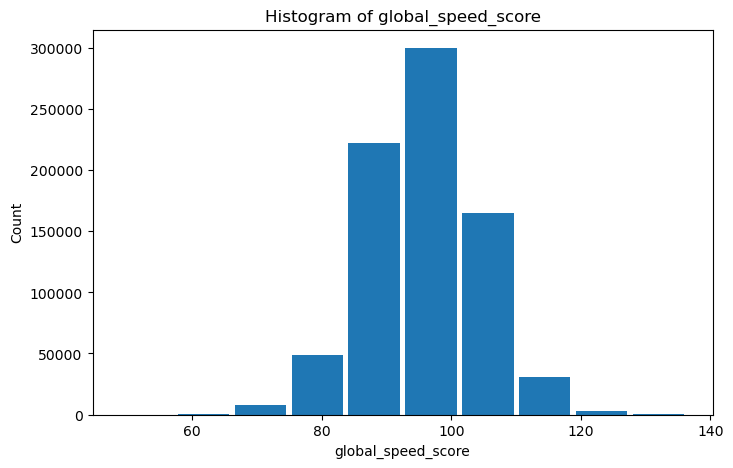

In [43]:
import matplotlib.pyplot as plt

# Convert the column to an RDD and use the histogram function
hist_result = (
    global_speed_score.select("global_speed_score_iq")
      .rdd
      .flatMap(lambda x: x)  # flatten out the column values
      .histogram(10)         # 10 bins by default
)

# hist_result returns a tuple (bins, counts)
# bins: list of bin boundaries
# counts: list of counts in each bin

bins = hist_result[0]
counts = hist_result[1]

plt.figure(figsize=(8, 5))
plt.bar(x=bins[:-1], height=counts, width=(bins[1] - bins[0]) * 0.9)
plt.xlabel("global_speed_score")
plt.ylabel("Count")
plt.title("Histogram of global_speed_score")
plt.show()

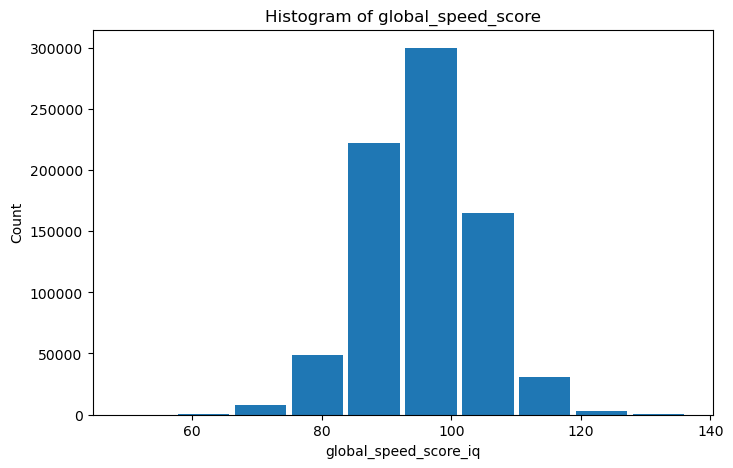

In [45]:
import matplotlib.pyplot as plt

# Convert the column to an RDD and use the histogram function
hist_result = (
    global_speed_score.select("global_speed_score_iq")
      .rdd
      .flatMap(lambda x: x)  # flatten out the column values
      .histogram(10)         # 10 bins by default
)

# hist_result returns a tuple (bins, counts)
# bins: list of bin boundaries
# counts: list of counts in each bin

bins = hist_result[0]
counts = hist_result[1]

plt.figure(figsize=(8, 5))
plt.bar(x=bins[:-1], height=counts, width=(bins[1] - bins[0]) * 0.9)
plt.xlabel("global_speed_score_iq")
plt.ylabel("Count")
plt.title("Histogram of global_speed_score")
plt.show()

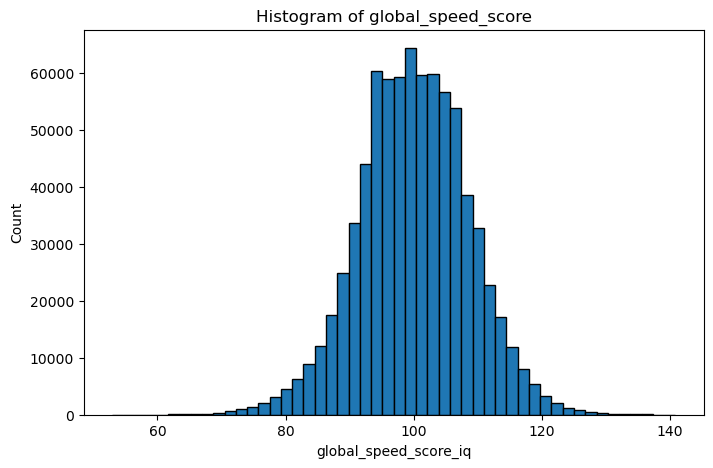

In [46]:
pdf = global_speed_score.select("global_speed_score_iq").toPandas()

plt.figure(figsize=(8, 5))
plt.hist(pdf["global_speed_score_iq"], bins=50, edgecolor='black')
plt.xlabel("global_speed_score_iq")
plt.ylabel("Count")
plt.title("Histogram of global_speed_score")
plt.show()

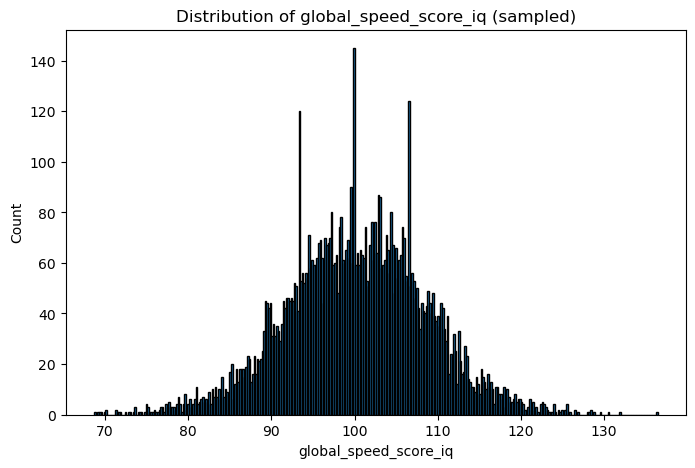

In [47]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# If the DataFrame is huge, take a sample to avoid OOM on driver
pdf = (global_speed_score
       .select("global_speed_score_iq")
       .dropna()
       .sample(withReplacement=False, fraction=0.01, seed=42)  # e.g., 1% sample
       .toPandas()
      )

plt.figure(figsize=(8, 5))
plt.hist(pdf["global_speed_score_iq"], bins=350, edgecolor='black')
plt.title("Distribution of global_speed_score_iq (sampled)")
plt.xlabel("global_speed_score_iq")
plt.ylabel("Count")
plt.show()

In [51]:
import pyspark.sql.functions as F

high_scores_df = (
    global_speed_score
    .select("horse_id", "horse_name", "global_speed_score_iq")
    .filter(
        (F.col("global_speed_score_iq") >= 110) &
        (F.col("global_speed_score_iq") <= 140)
    )
)

# Show them
high_scores_df.show(truncate=False)

# Or collect to the driver if you want to iterate in Python
results = high_scores_df.collect()
for row in results:
    print(row["horse_id"], row["horse_name"], row["global_speed_score_iq"])

+--------+------------------+---------------------+
|horse_id|horse_name        |global_speed_score_iq|
+--------+------------------+---------------------+
|6433.0  |Miss Jax          |112.05891319766934   |
|9923.0  |Look Up to Heaven |110.92626807306291   |
|548895.0|Bustin Away       |115.86175673959517   |
|414856.0|Beautiful Mandate |113.81233767514053   |
|68353.0 |Gift of Gab       |115.85286029213793   |
|596.0   |Blanca            |113.98110743992999   |
|99306.0 |Wicked Mercury    |116.06073296008516   |
|80631.0 |Journeyman        |111.8595423254643    |
|408519.0|No Cost           |117.90520598128622   |
|10831.0 |He's Smokin Now   |111.4349900152532    |
|417469.0|Prince of Monaco  |113.41345034331      |
|29728.0 |Sweet Willemina   |111.28040450083147   |
|460128.0|Run Chata         |111.25365445509765   |
|482735.0|Friday I'm in Love|111.21813624319066   |
|542010.0|Guest of Honor    |110.45944992513722   |
|70525.0 |Bulletsrevenge    |111.89724040635014   |
|41877.0 |St

405560.0 Jazz With Denis 111.39683963501102
2947.0 Moiraine 112.73149509057392
4536.0 County Court 114.40569526790898
892898.0 Rampagius 111.7189619936034
5104.0 Haveulostyourmind 111.37343489417356
54887.0 Pearl's Code 126.2424782146636
3006.0 More Ransom 112.49935491376598
14500.0 Bertrada 112.40921141720911
10264.0 Violent Rock 121.14615011979225
48785.0 Cabeza de Tortuga 114.72680326164051
420391.0 Span 117.74263404519769
1087572.0 Dynamitendiamonds 112.90546318499135
522514.0 Mary's Reward 111.15405780274521
11652.0 Magnetron 112.32219748261382
6430.0 Cha Ching Charlie 110.00980158665237
18940.0 Hyperbolist 110.61583919908256
97045.0 Sailor Speed 112.8583790404807
199849.0 Bold Connection 112.97879305715686
403833.0 Theirregistrdimnot 112.65537118044725
9567.0 Bricco 111.7256873163013
803100.0 Waitlist 110.90858597522056
24657.0 Jest Above 113.84828395694034
4991.0 Leeloo 120.85695826079532
457740.0 Playfulasitgets 114.76625822880592
11446.0 High Fire 110.13652633688133
69689.0 Fa

373261.0 Dontonio 112.29364277797023
18937.0 Where's the Pumps 112.67813043682965
411431.0 Ramathorn 113.13941648389078
25742.0 Flawless Cat 116.90833442776079
11288.0 Irish Luna 117.2162399166117
220425.0 Puppymonkeybaby 114.58784156452886
25234.0 Hard Candy 111.96658866829434
25606.0 Free Sailin 114.00750631990908
161918.0 Peak Popularity 111.45174627245395
66494.0 Jolly Tommy 128.1045280496644
16795.0 Arkansas Bling 113.15559434150315
14862.0 Devil's Rule 120.55515841627681
423534.0 Remerton 111.37763963063443
109427.0 Midtown Lights 113.19024439220016
43775.0 Misty Cat 112.44420509976838
25742.0 Flawless Cat 118.04060150408489
362651.0 Up and Down 113.12435309926387
682280.0 Maghra (IRE) 110.39003464043509
178938.0 Coalinga Road 112.49048115605731
17750.0 The Black Strat 113.26732737962226
24950.0 Old Chestnut 112.46869351235331
81506.0 Backstage Bambi 120.08259471393316
25234.0 Hard Candy 122.77295811779574
187689.0 Nic's Bro 111.21062752538704
18937.0 Where's the Pumps 112.994921

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [53]:
# Group by what should be your PK columns
dup_check_df = (
    global_speed_score.groupBy("course_cd", "race_date", "race_number", "horse_id")
      .count()
      .filter("count > 1")  # means there's more than one row for that key
)

dup_check_df.show(truncate=False)

+---------+---------+-----------+--------+-----+
|course_cd|race_date|race_number|horse_id|count|
+---------+---------+-----------+--------+-----+
+---------+---------+-----------+--------+-----+



In [ ]:
# Count number of races
# Count the number of unique races
race_count = (
    global_speed_score
    .select("course_cd", "race_date", "race_number")
    .distinct()  # Get unique race combinations
    .count()
)

# Print the number of unique races
print(f"Total number of races: {race_count}")

In [ ]:
from pyspark.sql import functions as F

# Check if the column exists, and drop it if it does
if "horse_count" in global_speed_score.columns:
    global_speed_score = global_speed_score.drop("horse_count")

In [ ]:
# Count the number of horses in each race
race_horse_counts = (
    global_speed_score
    .groupBy("course_cd", "race_date", "race_number")
    .agg(F.count("saddle_cloth_number").alias("horse_count"))  # Count horses per race
)

# Join the count back to the main DataFrame
global_speed_score = global_speed_score.join(race_horse_counts, on=["course_cd", "race_date", "race_number"], how="left")

In [ ]:
# Define the race to filter (modify these values as needed)
selected_course = "TOP"
selected_date = "2025-03-01"  # Adjust as needed
selected_race = 2  # Adjust as needed

# Filter and sort the DataFrame
filtered_race = (
    global_speed_score
    .filter(
        (F.col("course_cd") == selected_course) &
        (F.col("race_date") == selected_date) &
        (F.col("race_number") == selected_race)
    )
    .select(
        "course_cd", 
        "race_date", 
        "race_number", 
        "horse_name", 
        "saddle_cloth_number", 
        "horse_count"
    )
    .orderBy(F.col("saddle_cloth_number").asc())  # Sort by saddle_cloth_number
)

# Show the filtered race details
filtered_race.show(truncate=False)

In [ ]:
# Filter the DataFrame for the specific race.
race_df = speed_score.filter(
    (F.col("course_cd") == "TGP") &
    (F.col("race_date") == F.lit("2025-02-23").cast("date")) &
    (F.col("race_number") == 2)
)

# Select and order the columns of interest.
race_df.select("saddle_cloth_number", "horse_name", "course_cd", "race_date", "race_number") \
       .orderBy("saddle_cloth_number") \
       .show(truncate=False)

In [ ]:
horse_embedding.printSchema()

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Define the list of TPD tracks you want to filter for
tpd_tracks = [
    'CNL', 'SAR', 'PIM', 'TSA', 'BEL', 'MVR', 'TWO', 'CLS', 'KEE', 'TAM', 'TTP', 'TKD', 
    'ELP', 'PEN', 'HOU', 'DMR', 'TLS', 'AQU', 'MTH', 'TGP', 'TGG', 'CBY', 'LRL', 
    'TED', 'IND', 'CTD', 'ASD', 'TCD', 'LAD', 'TOP'
]

# Convert saddle_cloth_number to Integer (if stored as string)
horse_embedding = horse_embedding.withColumn(
    "saddle_cloth_number", F.col("saddle_cloth_number").cast("int")
)

# Define window partitioned by race and ordered by saddle_cloth_number
race_window = Window.partitionBy("course_cd", "race_date", "race_number").orderBy("saddle_cloth_number")

# Add a column for expected saddle_cloth_number (incremental index starting at 1)
horse_embedding = horse_embedding.withColumn(
    "expected_number",
    F.row_number().over(race_window)
)

# Identify races where saddle_cloth_number != expected_number
races_with_gaps = (
    horse_embedding
    .filter(F.col("saddle_cloth_number") != F.col("expected_number"))
    .filter(F.col("course_cd").isin(tpd_tracks))  # <-- Track filter applied here
    .select("course_cd", "race_date", "race_number")
    .distinct()
)

# Show races with non-contiguous saddle cloth numbers from the specified tracks
races_with_gaps.show()

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Define the specific track(s) you want to filter for
selected_tracks = ['TOP']  # Change this to filter for different tracks

# Convert saddle_cloth_number to Integer (if stored as string)
horse_embedding = horse_embedding.withColumn(
    "saddle_cloth_number", F.col("saddle_cloth_number").cast("int")
)

# Define window partitioned by race and ordered by saddle_cloth_number
race_window = Window.partitionBy("course_cd", "race_date", "race_number").orderBy("saddle_cloth_number")

# Add a column for expected saddle_cloth_number (incremental index starting at 1)
horse_embedding = horse_embedding.withColumn(
    "expected_number",
    F.row_number().over(race_window)
)

# Identify races where saddle_cloth_number != expected_number
races_with_gaps = (
    horse_embedding
    .filter(F.col("saddle_cloth_number") != F.col("expected_number"))
    .filter(F.col("course_cd").isin(selected_tracks))  # <-- Filter for specific track(s)
    .select("course_cd", "race_date", "race_number")
    .distinct()
)

# Show races with non-contiguous saddle cloth numbers for the selected track(s)
races_with_gaps.show()

Approach

>1.	Find races where saddle cloth numbers are non-contiguous (already identified in races_with_gaps).

>2.	Use that list to filter the main dataset (horse_embedding) and retrieve the horses that are present in those races.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Convert saddle_cloth_number to Integer (if stored as string)
horse_embedding = horse_embedding.withColumn(
    "saddle_cloth_number", F.col("saddle_cloth_number").cast("int")
)

# Define window partitioned by race and ordered by saddle_cloth_number
race_window = Window.partitionBy("course_cd", "race_date", "race_number").orderBy("saddle_cloth_number")

# Add a column for expected saddle_cloth_number (incremental index starting at 1)
horse_embedding = horse_embedding.withColumn(
    "expected_number",
    F.row_number().over(race_window)
)

# Identify races where saddle_cloth_number != expected_number
races_with_gaps = (
    horse_embedding
    .filter(F.col("saddle_cloth_number") != F.col("expected_number"))
    .select("course_cd", "race_date", "race_number")
    .distinct()
)

# Now, retrieve all horses in these races so we can see what saddle cloth numbers are present
horses_in_missing_races = (
    horse_embedding
    .join(races_with_gaps, ["course_cd", "race_date", "race_number"])  # Join to get only races with gaps
    .select("course_cd", "race_date", "race_number", "horse_name", "saddle_cloth_number")
    .orderBy("course_cd", "race_date", "race_number", "saddle_cloth_number")  # Order for readability
)

# Show results
horses_in_missing_races.show(50, truncate=False)

In [ ]:
# Filter the DataFrame for the specific race.
race_df = horse_enhanced.filter(
    (F.col("course_cd") == "AQU") &
    (F.col("race_date") == F.lit("2025-02-23").cast("date")) &
    (F.col("race_number") == 10)
)

# Select and order the columns of interest.
race_df.select("saddle_cloth_number", "horse_name", "course_cd", "race_date", "race_number") \
       .orderBy("saddle_cloth_number") \
       .show(truncate=False)